In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

In [ ]:
# Install kaggle CLI if not already installed
!pip install -q kaggle

# Upload your kaggle.json file (from kaggle.com/account)
from google.colab import files
files.upload()  # Upload kaggle.json

# Configure kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and extract DialogSum
!kaggle datasets download -d marawanxmamdouh/dialogsum
!unzip dialogsum.zip

In [4]:
import pandas as pd

# Load the dataset
train_df = pd.read_csv('/content/CSV/train.csv')
val_df = pd.read_csv('/content/CSV/validation.csv')
test_df = pd.read_csv('/content/CSV/test.csv')

print("DialogSum Dataset Info:")
print(f"Train: {len(train_df):,} samples")
print(f"Validation: {len(val_df):,} samples")
print(f"Test: {len(test_df):,} samples")


DialogSum Dataset Info:
Train: 12,460 samples
Validation: 500 samples
Test: 1,500 samples


In [ ]:
train_df.head()

,id,dialogue,summary,topic
0,train_0,"#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. ...","Mr. Smith's getting a check-up, and Doctor Haw...",get a check-up
1,train_1,"#Person1#: Hello Mrs. Parker, how have you bee...",Mrs Parker takes Ricky for his vaccines. Dr. P...,vaccines
2,train_2,"#Person1#: Excuse me, did you see a set of key...",#Person1#'s looking for a set of keys and asks...,find keys
3,train_3,#Person1#: Why didn't you tell me you had a gi...,#Person1#'s angry because #Person2# didn't tel...,have a girlfriend
4,train_4,"#Person1#: Watsup, ladies! Y'll looking'fine t...",Malik invites Nikki to dance. Nikki agrees if ...,dance


In [ ]:
train_df.iloc[0]

,0
id,train_0
dialogue,"#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. ..."
summary,"Mr. Smith's getting a check-up, and Doctor Haw..."
topic,get a check-up


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
from transformers import AutoTokenizer

# Load tokenizer for the CORRECT model
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")
# Your existing preprocessing function works perfectly!
def preprocess_dialogue(dialogue, summary, max_input_length=512, max_output_length=128):
    """
    Preprocess dialogue-summary pair for training.
    No additional cleaning needed - data is clean!
    """
    # Tokenize dialogue (input)
    input_encodings = tokenizer(
        dialogue,  # Already clean: "#Person1#: Hi...\n#Person2#: I found..."
        truncation=True,
        padding=False,
        max_length=max_input_length,
        return_tensors=None
    )

    # Tokenize summary (target)
    target_encodings = tokenizer(
        summary,   # Already clean: "Mr. Smith's getting a check-up..."
        truncation=True,
        padding=False,
        max_length=max_output_length,
        return_tensors=None
    )

    return {
        'input_ids': input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

# Test it
sample = preprocess_dialogue(
    train_df.iloc[0]['dialogue'],
    train_df.iloc[0]['summary']
)

print("✅ Data is ready for fine-tuning!")
print(f"Input length: {len(sample['input_ids'])} tokens")
print(f"Target length: {len(sample['labels'])} tokens")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Data is ready for fine-tuning!
Input length: 271 tokens
Target length: 41 tokens


In [ ]:
from torch.utils.data import Dataset
import torch
from transformers import DataCollatorForSeq2Seq

class DialogSumDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_input_length=512, max_output_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dialogue = str(self.data.iloc[idx]['dialogue'])
        summary = str(self.data.iloc[idx]['summary'])

        # Ensure padding is applied here
        input_encodings = self.tokenizer(
            dialogue,
            truncation=True,
            padding='max_length',  # Add padding
            max_length=self.max_input_length,
            return_tensors=None
        )

        target_encodings = self.tokenizer(
            summary,
            truncation=True,
            padding='max_length', # Add padding
            max_length=self.max_output_length,
            return_tensors=None
        )

        return {
            'input_ids': input_encodings['input_ids'],
            'attention_mask': input_encodings['attention_mask'],
            'labels': target_encodings['input_ids']
        }

# Create datasets (use smaller subset for faster training)
train_dataset = DialogSumDataset(train_df, tokenizer)  # Use 5K samples for speed
val_dataset = DialogSumDataset(val_df, tokenizer)      # Use 500 samples for validation

print(f"✅ Datasets created!")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

✅ Datasets created!
Train samples: 12460
Validation samples: 500


In [ ]:
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSeq2SeqLM
model_name = "sshleifer/distilbart-cnn-12-6"
# Load model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Enable gradient checkpointing to save memory
model.gradient_checkpointing_enable()

# Training arguments (optimized for efficiency)
training_args = TrainingArguments(
    output_dir="./dialogsum-finetuned",
    num_train_epochs=4,  # Start with 2 epochs
    per_device_train_batch_size=2,  # Adjust based on your GPU (2 is safe)
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,  # Simulate larger batch size (2*8 = effective batch size 16)
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="steps", # Corrected parameter name
    eval_steps=200,
    save_strategy="steps", # Corrected parameter name
    save_steps=200, # Changed save_steps to be a multiple of eval_steps
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=2,
    prediction_loss_only=True,
    fp16=True,  # Enable mixed precision for speed and memory
    report_to="none",  # Disable logging to save memory
    dataloader_pin_memory=True,
)

print("✅ Training arguments configured!")
print(f"Model parameters: {model.num_parameters() / 1e6:.1f}M")

✅ Training arguments configured!
Model parameters: 305.5M


In [ ]:
# Create trainer
# Initialize DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator, # Add data collator
)

print("Starting fine-tuning...")
print(f"Training on {len(train_dataset)} samples")
print(f"Validating on {len(val_dataset)} samples")

# Start training
trainer.train()

/tmp/ipython-input-1349313589.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting fine-tuning...
Training on 12460 samples
Validating on 500 samples


Step,Training Loss,Validation Loss
200,0.402700,0.350904
400,0.361800,0.327278
600,0.354100,0.317755
800,0.310700,0.313314
1000,0.257200,0.308395
1200,0.250600,0.308564
1400,0.267100,0.302411
1600,0.198500,0.323064
1800,0.193600,0.319680
2000,0.192700,0.321054


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:4037: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=3116, training_loss=0.3573248761303159, metrics={'train_runtime': 6948.9561, 'train_samples_per_second': 7.172, 'train_steps_per_second': 0.448, 'total_flos': 3.857396917075968e+16, 'train_loss': 0.3573248761303159, 'epoch': 4.0})

In [ ]:
# Save the fine-tuned model
trainer.save_model("./dialogsum-finetuned-final")
tokenizer.save_pretrained("./dialogsum-finetuned-final")

print("✅ Fine-tuning complete!")
print("Model saved to ./dialogsum-finetuned-final")

In [5]:
# Install evaluation library if not already installed
!pip install -q evaluate rouge_score

# Load ROUGE metric
from evaluate import load
rouge = load('rouge')

# Load your test dataset
import pandas as pd

print(f"Test set size: {len(test_df)} samples")
print("First test sample:")
print("DIALOGUE:", test_df.iloc[0]['dialogue'][:200] + "...")
print("SUMMARY:", test_df.iloc[0]['summary'])

Test set size: 1500 samples
First test sample:
DIALOGUE: #Person1#: Ms. Dawson, I need you to take a dictation for me.
#Person2#: Yes, sir...
#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?
#Per...
SUMMARY: Ms. Dawson helps #Person1# to write a memo to inform every employee that they have to change the communication method and should not use Instant Messaging anymore.


In [7]:
from transformers import pipeline
import torch
# Load your fine-tuned model
fine_tuned_summarizer = pipeline(
    "summarization",
    model="./dialogsum-finetuned-final",  # Path to your fine-tuned model
    tokenizer="./dialogsum-finetuned-final",
    device=0 if torch.cuda.is_available() else -1,
    # Set default parameters for summarization
    max_length=80,      # Maximum summary length
    min_length=20,      # Minimum summary length
    do_sample=False,    # Use greedy decoding
    truncation=True     # Truncate long dialogues
)

print("✅ Fine-tuned model loaded!")

/usr/local/lib/python3.12/dist-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(
Device set to use cuda:0


✅ Fine-tuned model loaded!


In [8]:
# Generate summaries for first 100 test samples (adjust as needed)
N_EVAL_SAMPLES = 100  # Use 100 for quick eval, or more if you have time
test_subset = test_df.head(N_EVAL_SAMPLES)

print(f"⏳ Generating summaries for {len(test_subset)} test samples...")

generated_summaries = []
for i in range(len(test_subset)):
    if i % 10 == 0:
        print(f"Progress: {i}/{len(test_subset)}", end="\r")

    result = fine_tuned_summarizer(
        test_subset.iloc[i]['dialogue'],
        max_length=80,
        min_length=20,
        do_sample=False
    )
    generated_summaries.append(result[0]['summary_text'])

print(f"\n✅ Generated {len(generated_summaries)} summaries")

⏳ Generating summaries for 100 test samples...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Your max_length is set to 80, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 80, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 80, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Your max_length is set to 80, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 80, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 80, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Progress: 90/100
✅ Generated 100 summaries


In [9]:
# Compute ROUGE scores
print("⏳ Computing ROUGE scores...")
reference_summaries = test_subset['summary'].tolist()

rouge_results = rouge.compute(
    predictions=generated_summaries,
    references=reference_summaries
)

# Print results
print("\n📊 ROUGE SCORES (DialogSum Test Set):")
for metric, score in rouge_results.items():
    print(f"{metric.upper()}: {score:.4f}")

# Compare with your previous CNN/DM results
print(f"\n🎯 COMPARISON:")
print(f"DialogSum Fine-tuned ROUGE-1: {rouge_results['rouge1']:.4f}")
print(f"Previous CNN/DM ROUGE-1: 0.3564")
print(f"Improvement: {rouge_results['rouge1'] - 0.3564:.4f}")

⏳ Computing ROUGE scores...

📊 ROUGE SCORES (DialogSum Test Set):
ROUGE1: 0.4081
ROUGE2: 0.1470
ROUGEL: 0.3315
ROUGELSUM: 0.3307

🎯 COMPARISON:
DialogSum Fine-tuned ROUGE-1: 0.4081
Previous CNN/DM ROUGE-1: 0.3564
Improvement: 0.0517


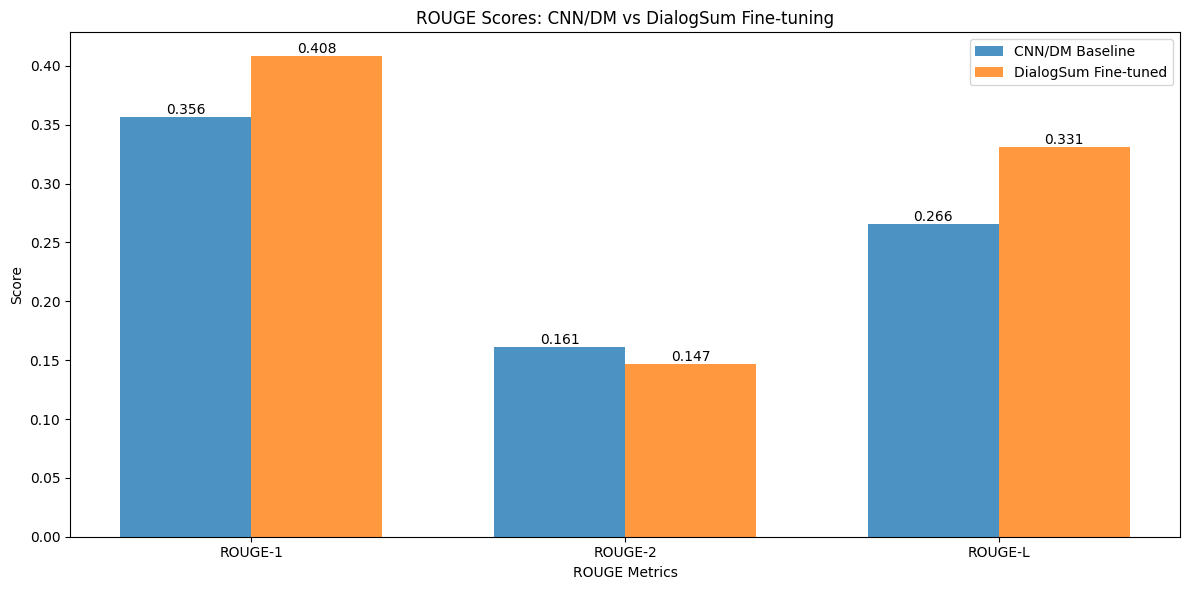

In [18]:
# ROUGE scores data
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
previous_scores = [0.3564, 0.1608, 0.2660]  # Your CNN/DM results
fine_tuned_scores = [
    rouge_results['rouge1'],
    rouge_results['rouge2'],
    rouge_results['rougeL']
]

# Create comparison plot
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, previous_scores, width, label='CNN/DM Baseline', alpha=0.8)
bars2 = ax.bar(x + width/2, fine_tuned_scores, width, label='DialogSum Fine-tuned', alpha=0.8)

ax.set_xlabel('ROUGE Metrics')
ax.set_ylabel('Score')
ax.set_title('ROUGE Scores: CNN/DM vs DialogSum Fine-tuning')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()